# Single Cell Sequencing: data agregation and quality control USING UMIs

We use Scanpy for quality control filtering of data and for basic analysis (such as dimensionality reduction and plotting).

Adata file format is used as a variable for all the notebook.

We add information from other .txt files that were provided by SciLife lab regarding the real or kept cell barcodes and the mapping from the barcodes to the position in the well.

We use the information of the position in the plate to define which cells were correponding to mock or different stimuli experiments, as well as to include the level of red and green fluorecence of those cells (from CAMPARI).

Output of this notebook is the agreagated and quality controled data saved as campary_scs.h5ad (after quality control)

In [1]:
# !pip install --quiet anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import os 
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
import warnings
import config as general_paths
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.1.3 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [2]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
local_path = general_paths.local_path


In [3]:

### filtering criteria

MIN_COUNTS = 10000
MIN_GENES = 3000
MIN_CELLS = 5
N_GENES_BY_COUNTS = 12500
HIGHLY_VARIABLE_GENES = 15000
mito_threshold = 0.05


## SECTION I: Data loading, cell selection and data agregation

Here we declare file paths assuming fastq files had been already decompressed. 

We need adata file path (kallisto output), kept cell barcodes file (provided by scilife lab), 
all cell barcodes file (kallisto output), plate-cell barcode ID file (provided by scilife lab),
and flourecence information (file manually created with plate position info, flourence level, and our cell number).

This section loads all these files, and the final output is an anndata format count matrix with data agregation from all plates.

In [6]:
# load the unfiltered matrix and define all paths for storing data

results_file_sample1 = os.path.join(local_path,'sample1/counts_unfiltered_umi/adata.h5ad')  # the file that will store the analysis results
results_file_sample2 = os.path.join(local_path,'sample2/counts_unfiltered_umi/adata.h5ad') # the file that will store the analysis results
results_file_sample3 = os.path.join(local_path,'sample3/counts_unfiltered_umi/adata.h5ad')  # the file that will store the analysis results
results_file_sample4 = os.path.join(local_path,'sample4/counts_unfiltered_umi/adata.h5ad')  # the file that will store the analysis results
results_file_sample5 = os.path.join(local_path,'sample5/counts_unfiltered_umi/adata.h5ad') # the file that will store the analysis results
results_file_sample6 = os.path.join(local_path,'sample6/counts_unfiltered_umi/adata.h5ad') 
results_file_sample7 = os.path.join(local_path,'sample7/counts_unfiltered_umi/adata.h5ad')
#txt file with kept cells
cell_barcode_file_sample1 = os.path.join(local_path,'sample1/counts_umiR/SS3_22_291kept_barcodes.txt')
cell_barcode_file_sample2 = os.path.join(local_path,'sample2/counts_umiR/SS3_23_049kept_barcodes.txt')
cell_barcode_file_sample3 = os.path.join(local_path,'sample3/counts_umiR/SS3_23_127kept_barcodes.txt')
cell_barcode_file_sample4 = os.path.join(local_path,'sample4/counts_umiR/SS3_23_193kept_barcodes.txt')
cell_barcode_file_sample5 = os.path.join(local_path,'sample5/counts_umiR/SS3_23_195kept_barcodes.txt')
cell_barcode_file_sample6 = os.path.join(local_path,'sample6/counts_umiR/SS3_23_325kept_barcodes.txt')
cell_barcode_file_sample7= os.path.join(local_path,'sample7/counts_umiR/SS3_23_327kept_barcodes.txt')
#read barcodes with kalisto
cell_barcode_file_new_sample1 = os.path.join(local_path,'sample1/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample2 = os.path.join(local_path,'sample2/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample3 = os.path.join(local_path,'sample3/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample4 = os.path.join(local_path,'sample4/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample5 = os.path.join(local_path,'sample5/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample6 = os.path.join(local_path,'sample6/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
cell_barcode_file_new_sample7 = os.path.join(local_path,'sample7/counts_unfiltered_umi/cells_x_genes.barcodes.txt')
#txt file with well barcodes. the text contains the cell barcode corresponding to each position in the plate
well_barcode_sample1 = os.path.join(local_path,'sample1/counts_umiR/SS3_22_291.well_barcodes.txt')
well_barcode_sample2 = os.path.join(local_path,'sample2/counts_umiR/SS3_23_049.well_barcodes.txt')
well_barcode_sample3 = os.path.join(local_path,'sample3/counts_umiR/SS3_23_127.well_barcodes.txt')
well_barcode_sample4 = os.path.join(local_path,'sample4/counts_umiR/SS3_23_193.well_barcodes.txt')
well_barcode_sample5 = os.path.join(local_path,'sample5/counts_umiR/SS3_23_195.well_barcodes.txt')
well_barcode_sample6 = os.path.join(local_path,'sample6/counts_umiR/SS3_23_325.well_barcodes.txt')
well_barcode_sample7 = os.path.join(local_path,'sample7/counts_umiR/SS3_23_327.well_barcodes.txt')
###upload excel with red and green flourecence from campari (has information about position in plate and fluorecence level)
florecence_1_file_path =os.path.join(local_path,'sample1/counts_umiR/well_1_data_base.csv')
florecence_2_file_path = os.path.join(local_path,'sample2/counts_umiR/well_2_data_base.csv')
florecence_3_file_path = os.path.join(local_path,'sample3/counts_umiR/well_3_data_base.csv')
florecence_4_file_path = os.path.join(local_path,'sample4/counts_umiR/well_4_data_base.csv')
florecence_5_file_path = os.path.join(local_path,'sample5/counts_umiR/well_5_data_base.csv')
florecence_6_file_path = os.path.join(local_path,'sample6/counts_umiR/well_6_data_base.csv')
florecence_7_file_path = os.path.join(local_path,'sample7/counts_umiR/well_7_data_base.csv')

In [7]:
### load raw adata file using adata libraty
sample1 = ad.read_h5ad(results_file_sample1)
sample2 = ad.read_h5ad(results_file_sample2)
sample3 = ad.read_h5ad(results_file_sample3)
sample4 = ad.read_h5ad(results_file_sample4)
sample5 = ad.read_h5ad(results_file_sample5)
sample6 = ad.read_h5ad(results_file_sample6)
sample7 = ad.read_h5ad(results_file_sample7)
### read fluorecence levels
flourecence1 = pd.read_csv(florecence_1_file_path)
flourecence2 = pd.read_csv(florecence_2_file_path)
flourecence3 = pd.read_csv(florecence_3_file_path)
flourecence4 = pd.read_csv(florecence_4_file_path)
flourecence5 = pd.read_csv(florecence_5_file_path)
flourecence6 = pd.read_csv(florecence_6_file_path)
flourecence7 = pd.read_csv(florecence_7_file_path)
### read kept barcodes and barcodes provided by kalisto
df_1_sample1 = pd.read_csv(cell_barcode_file_sample1, delimiter = "\,")
df_2_sample1 = pd.read_csv(cell_barcode_file_new_sample1)

df_1_sample2 = pd.read_csv(cell_barcode_file_sample2, delimiter = "\,")
df_2_sample2 = pd.read_csv(cell_barcode_file_new_sample2)

df_1_sample3 = pd.read_csv(cell_barcode_file_sample3, delimiter = "\,")
df_2_sample3 = pd.read_csv(cell_barcode_file_new_sample3)

df_1_sample4 = pd.read_csv(cell_barcode_file_sample4, delimiter = "\,")
df_2_sample4 = pd.read_csv(cell_barcode_file_new_sample4)

df_1_sample5 = pd.read_csv(cell_barcode_file_sample5, delimiter = "\,")
df_2_sample5 = pd.read_csv(cell_barcode_file_new_sample5)

df_1_sample6 = pd.read_csv(cell_barcode_file_sample6, delimiter = "\,")
df_2_sample6 = pd.read_csv(cell_barcode_file_new_sample6)

df_1_sample7 = pd.read_csv(cell_barcode_file_sample7, delimiter = "\,")
df_2_sample7 = pd.read_csv(cell_barcode_file_new_sample7)



In [11]:

### merge data base. Merge information about cell barcode and fluorecence 
### (using as common demonimator the position in the plate)
barcode_list_sample1 = list(df_1_sample1['XC'])
well_df_sample1 = pd.read_csv(well_barcode_sample1, sep = "\t")
mergedRes1 = pd.merge(well_df_sample1 , flourecence1, on ='well_id')

barcode_list_sample2 = list(df_1_sample2['XC'])
well_df_sample2 = pd.read_csv(well_barcode_sample2, sep = "\t")
mergedRes2 = pd.merge(well_df_sample2 , flourecence2, on ='well_id')

barcode_list_sample3 = list(df_1_sample3['XC'])
well_df_sample3 = pd.read_csv(well_barcode_sample3, sep = "\t")
mergedRes3 = pd.merge(well_df_sample3 , flourecence3, on ='well_id')

barcode_list_sample4 = list(df_1_sample4['XC'])
well_df_sample4 = pd.read_csv(well_barcode_sample4, sep = "\t")
mergedRes4 = pd.merge(well_df_sample4 , flourecence4, on ='well_id')

barcode_list_sample5 = list(df_1_sample5['XC'])
well_df_sample5 = pd.read_csv(well_barcode_sample5, sep = "\t")
mergedRes5 = pd.merge(well_df_sample5 , flourecence5, on ='well_id')

barcode_list_sample6 = list(df_1_sample6['XC'])
well_df_sample6 = pd.read_csv(well_barcode_sample6, sep = "\t")
mergedRes6 = pd.merge(well_df_sample6 , flourecence6, on ='well_id')

barcode_list_sample7 = list(df_1_sample7['XC'])
well_df_sample7 = pd.read_csv(well_barcode_sample7, sep = "\t")
mergedRes7 = pd.merge(well_df_sample7 , flourecence7, on ='well_id')

In [9]:
def barcode_check(df_1,df_2,barcode_list,mergedRes):

    #print(barcode_list)
    kept_cells = np.zeros((len(df_1),))
    well_id = np.zeros((len(df_1),))

    red_f = np.zeros((len(df_1),))
    green_f = np.zeros((len(df_1),))
    stimulus = np.zeros((len(df_1),))
    cell_id = np.zeros((len(df_1),))

    index_vector = np.zeros((len(df_1),))
    count = 0
    counter = 0
    for i in range(len(df_2)):
        x = df_2.iloc[i]['Barcodes']
        if x in barcode_list:
            index = barcode_list.index(x)
            index_vector[count] = index
            if len(np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)):
                counter+=1
                position = np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)[0][0]
                stimulus[index] = mergedRes['stimulus'].where(mergedRes['bc_set'] == x)[position]
                red_f[index] = mergedRes['red_f'].where(mergedRes['bc_set'] == x)[position]
                green_f[index] = mergedRes['green_f'].where(mergedRes['bc_set'] == x)[position]
                cell_id[index] = mergedRes['cell_number'].where(mergedRes['bc_set'] == x)[position]
                kept_cells[index] = int(i)
                well_id[index] = 1
                count +=1
    #kept_cells = np.unique(kept_cells)
    count = len(df_1)
    # replace all nans to zeros
    np.nan_to_num(well_id,copy=False)
    np.nan_to_num(stimulus,copy=False)
    np.nan_to_num(red_f,copy=False)
    np.nan_to_num(green_f,copy=False)
    
    
    return kept_cells, well_id,stimulus,red_f,green_f, cell_id

In [12]:

kept_cells1, well_id1,stimulus_1,red_f1,green_f1, cell_id1 = barcode_check(df_1_sample1,df_2_sample1,barcode_list_sample1,mergedRes1)

kept_cells2, well_id2,stimulus_2,red_f2,green_f2, cell_id2 = barcode_check(df_1_sample2,df_2_sample2,barcode_list_sample2,mergedRes2)

kept_cells3, well_id3,stimulus_3,red_f3,green_f3, cell_id3 = barcode_check(df_1_sample3,df_2_sample3,barcode_list_sample3,mergedRes3)

kept_cells4, well_id4,stimulus_4,red_f4,green_f4, cell_id4 = barcode_check(df_1_sample4,df_2_sample4,barcode_list_sample4,mergedRes4)

kept_cells5, well_id5,stimulus_5,red_f5,green_f5, cell_id5 = barcode_check(df_1_sample5,df_2_sample5,barcode_list_sample5,mergedRes5)
kept_cells6, well_id6,stimulus_6,red_f6,green_f6, cell_id6 = barcode_check(df_1_sample6,df_2_sample6,barcode_list_sample6,mergedRes6)
kept_cells7, well_id7,stimulus_7,red_f7,green_f7, cell_id7 = barcode_check(df_1_sample7,df_2_sample7,barcode_list_sample7,mergedRes7)


In [14]:
### select only kept cells
sample1.var_names_make_unique() 
sample2.var_names_make_unique() 
sample3.var_names_make_unique() 
sample4.var_names_make_unique() 
sample5.var_names_make_unique() 
sample6.var_names_make_unique() 
sample7.var_names_make_unique() 

adata1 = sample1[kept_cells1.astype(int),:]
adata2 = sample2[kept_cells2.astype(int),:]
adata3 = sample3[kept_cells3.astype(int),:]
adata4 = sample4[kept_cells4.astype(int),:]
adata5 = sample5[kept_cells5.astype(int),:]
adata6 = sample6[kept_cells6.astype(int),:]
adata7 = sample7[kept_cells7.astype(int),:]

### add campari information to adata structure
adata1.obs['stimulus'] = stimulus_1 
adata1.obs['red'] = red_f1
adata1.obs['green'] = green_f1
adata1.obs['well_id'] = well_id1
adata1.obs['cell_id'] = cell_id1

adata2.obs['stimulus'] = stimulus_2
adata2.obs['red'] = red_f2
adata2.obs['green'] = green_f2
adata2.obs['well_id'] = well_id2
adata2.obs['cell_id'] = cell_id2

adata3.obs['stimulus'] = stimulus_3
adata3.obs['red'] = red_f3
adata3.obs['green'] = green_f3
adata3.obs['well_id'] = well_id3
adata3.obs['cell_id'] = cell_id3

adata4.obs['stimulus'] = stimulus_4
adata4.obs['red'] = red_f4
adata4.obs['green'] = green_f4
adata4.obs['well_id'] = well_id4
adata4.obs['cell_id'] = cell_id4


adata5.obs['stimulus'] = stimulus_5
adata5.obs['red'] = red_f5
adata5.obs['green'] = green_f5
adata5.obs['well_id'] = well_id5
adata5.obs['cell_id'] = cell_id5

adata6.obs['stimulus'] = stimulus_6
adata6.obs['red'] = red_f6
adata6.obs['green'] = green_f6
adata6.obs['well_id'] = well_id6
adata6.obs['cell_id'] = cell_id6


adata7.obs['stimulus'] = stimulus_7
adata7.obs['red'] = red_f7
adata7.obs['green'] = green_f7
adata7.obs['well_id'] = well_id7
adata7.obs['cell_id'] = cell_id7


In [15]:

### data integration

adata_1 = adata1.concatenate(adata2, join='outer', batch_categories=['sample1', 'sample2'], index_unique='-')
adata_2 = adata_1.concatenate(adata3, join='outer', batch_categories=['sample12', 'sample3'], index_unique='-')
adata_3 = adata_2.concatenate(adata4, join='outer', batch_categories=['sample123', 'sample4'], index_unique='-')
#adata_4 = adata_3.concatenate(adata5, join='outer', batch_categories=['sample1234', 'sample5'], index_unique='-')
#adata_5 = adata_4.concatenate(adata6, join='outer', batch_categories=['sample12345', 'sample6'], index_unique='-')
#adata_6 = adata_5.concatenate(adata7, join='outer', batch_categories=['sample123456', 'sample7'], index_unique='-')

adata = adata_3.concatenate(adata5, join='outer', batch_categories=['sample1234', 'sample5'], index_unique='-')

adata.var_names_make_unique() 
print('Number of cells:', adata.X.shape[0])
print('Number of genes:', adata.X.shape[1])

Number of cells: 1920
Number of genes: 34183


In [11]:
adata.write_h5ad(
    os.path.join(output_path , 'campari_scs_raw.h5ad'),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

## SECTION II: Quality control

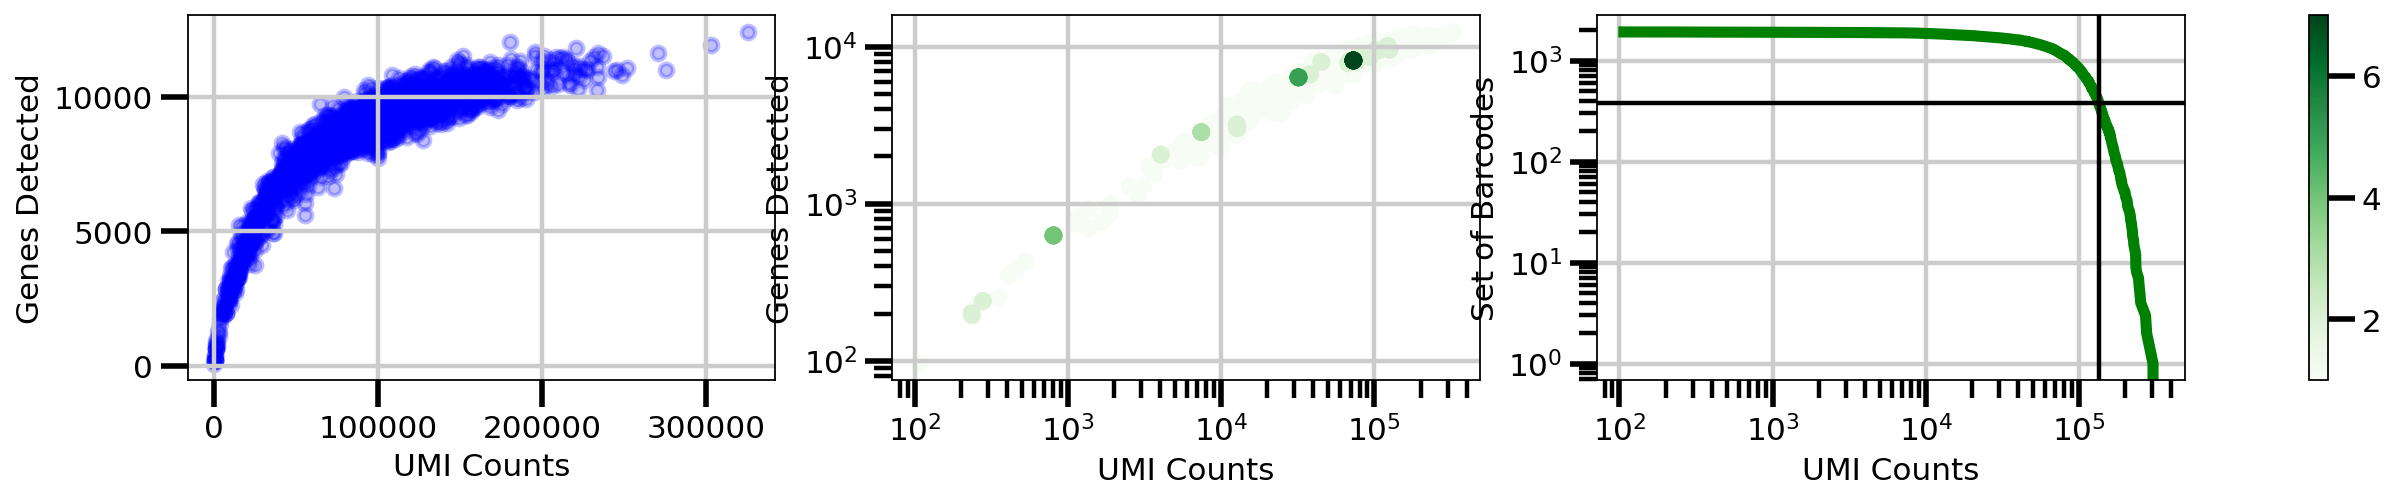

In [16]:
#### RECREATE PLOTS THAT ARE GIVEN IN THE REPORT BY SCILAB!

#Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(1,3)
x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]
ax[0].scatter(x, y, color="b", alpha=0.25)
ax[0].set_ylabel("Genes Detected")
ax[0].set_xlabel("UMI Counts")
#ax.set_xscale('log')
#ax.set_yscale('log')

#histogram definition
bins = [1500, 1500] # number of bins
# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)
# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

s = ax[1].scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel("UMI Counts")
ax[1].set_ylabel("Genes Detected")


expected_num_cells =  380#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

ax[2].loglog(knee, range(len(knee)), linewidth=5, color="g")
ax[2].axvline(x=knee[expected_num_cells], linewidth=2, color="k")
ax[2].axhline(y=expected_num_cells, linewidth=2, color="k")

ax[2].set_xlabel("UMI Counts")
ax[2].set_ylabel("Set of Barcodes")

#plt.grid(True, which="both")

fig.set_size_inches([20,3])
plt.show()
fig.savefig(os.path.join(figure_path , 'QC_UMI_genes_counts_pre_filtering.png'))

In [13]:
### WE NEED TO CONVERT CODENAMES INTO REAL GENE NAMES
### FOR THAT WE USE T2G VARIABLE THAT OPENS T2G FILE (FILE WITH LINK BETWEEN GENE CODE AND GENE NAME)

# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(axis = 1) ## this sums over genes
x =  adata.X.sum(axis = 1)
adata.obs['log_counts'] = np.log(x)
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

In [20]:
def find_match(id_list,t2g_df):
    gene_ids = t2g_df["gene_id"].tolist()
    gene_names = t2g_df["gene_name"].tolist()
    matched_ordered_gene_names = []
    missed = 0
    for i,el in enumerate(id_list):
        if el in gene_ids:
            idx = gene_ids.index(el)
            matched_ordered_gene_names.append(gene_names[idx])
        else:
            matched_ordered_gene_names.append(el)
            missed+=1
    gene_names_arr = np.asarray(matched_ordered_gene_names)
    # np.isnan(gene_names_arr).any()
    print(f"Found nans {gene_names_arr.dtype}")
    return gene_names_arr

In [21]:
#### we need to read the t2g to be able to know which genes are mitochondrial!!!

# t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g = pd.read_csv("t2g.txt", header=None,  names=["some_id", "gene_id", "gene_name", "gene_variant","num1","num2","num3","pos_neg"], sep="\t")
t2g.index = t2g.gene_id### FOR THAT WE USE T2G VARIABLE THAT OPENS T2G FILE (FILE WITH LINK BETWEEN GENE CODE AND GENE NAME)
print(len(t2g))
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]
print(len(t2g))
# adata.var["gene_id"] = adata.var.index.values
# adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
# adata.var.index = adata.var["gene_name"]

# mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# y = np.sum(adata[:, mt_gene_mask].X, axis=1).A1.reshape(-1,)
# z = np.array(adata.obs['n_counts']).reshape(-1,)

# adata.obs['mt_frac'] = y/z

# adata.var["mt"] = adata.var_names.str.startswith("MT-")
# sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
# sc.pl.highest_expr_genes(adata, n_top=5)

126126
34183


In [22]:
found_gene_names = find_match(adata.var.index.values.tolist(),t2g)
ctr = 0
for el in found_gene_names:
    if el.startswith("mt-"):
        ctr+=1
ctr
# adata.var_names.str.startswith('mt-')


Found nans <U32


13

In [37]:


mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
y = np.sum(adata[:, mt_gene_mask].X, axis=1).A1.reshape(-1,)
z = np.array(adata.obs['n_counts']).reshape(-1,)

adata.obs['mt_frac'] = y/z


# adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# #adata.var["mt"] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
# #sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
# sc.pl.highest_expr_genes(adata, n_top=10)


AttributeError: 'float' object has no attribute 'startswith'

In [38]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
### check for mitochandrial mRNA
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

#### change percent to fraction!!!!!

adata.obs['fraction_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
sc.pl.violin(adata, ['n_genes', 'n_counts', 'fraction_mito'],
             jitter=0.4, multi_panel=True)

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [15]:
### TODO!!!!!!!!!!!#################################################################
### lets check the mitochondiral genes and filter!!!!!
####################################################################################


# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))
#cell_subset = sc.pp.filter_cells(adata, min_counts = 1000)
#filter1 = kept_cells_stimuli[cell_subset[0]]
#red_filter1 = red_intensity[cell_subset[0]]
#green_filter1 = green_intensity[cell_subset[0]]
#well_id_filter1 = well_id[cell_subset[0]]
sc.pp.filter_cells(adata, min_counts = 1000)

print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
#cell_subset = sc.pp.filter_cells(adata, min_genes = 1000,inplace=False)
#filter2 = filter1[cell_subset[0]]
#red_filter2 = red_filter1[cell_subset[0]]
#green_filter2 = green_filter1[cell_subset[0]]
#well_id_filter2 = well_id_filter1[cell_subset[0]]
sc.pp.filter_cells(adata, min_genes = 1000)

#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=5)
#sc.pp.filter_genes(adata, min_counts=10)

Total number of cells: 1152
filtered out 12 cells that have less than 1000 counts
Number of cells after min count filter: 1140
filtered out 6 cells that have less than 1000 genes expressed
Total number of genes: 55421
filtered out 29491 genes that are detected in less than 5 cells


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(1012, 25930)


/tmp/ipykernel_23496/577317756.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mito_list.append(adata.obs['fraction_mito'][i])
/home/melma31/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/melma31/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/melma31/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

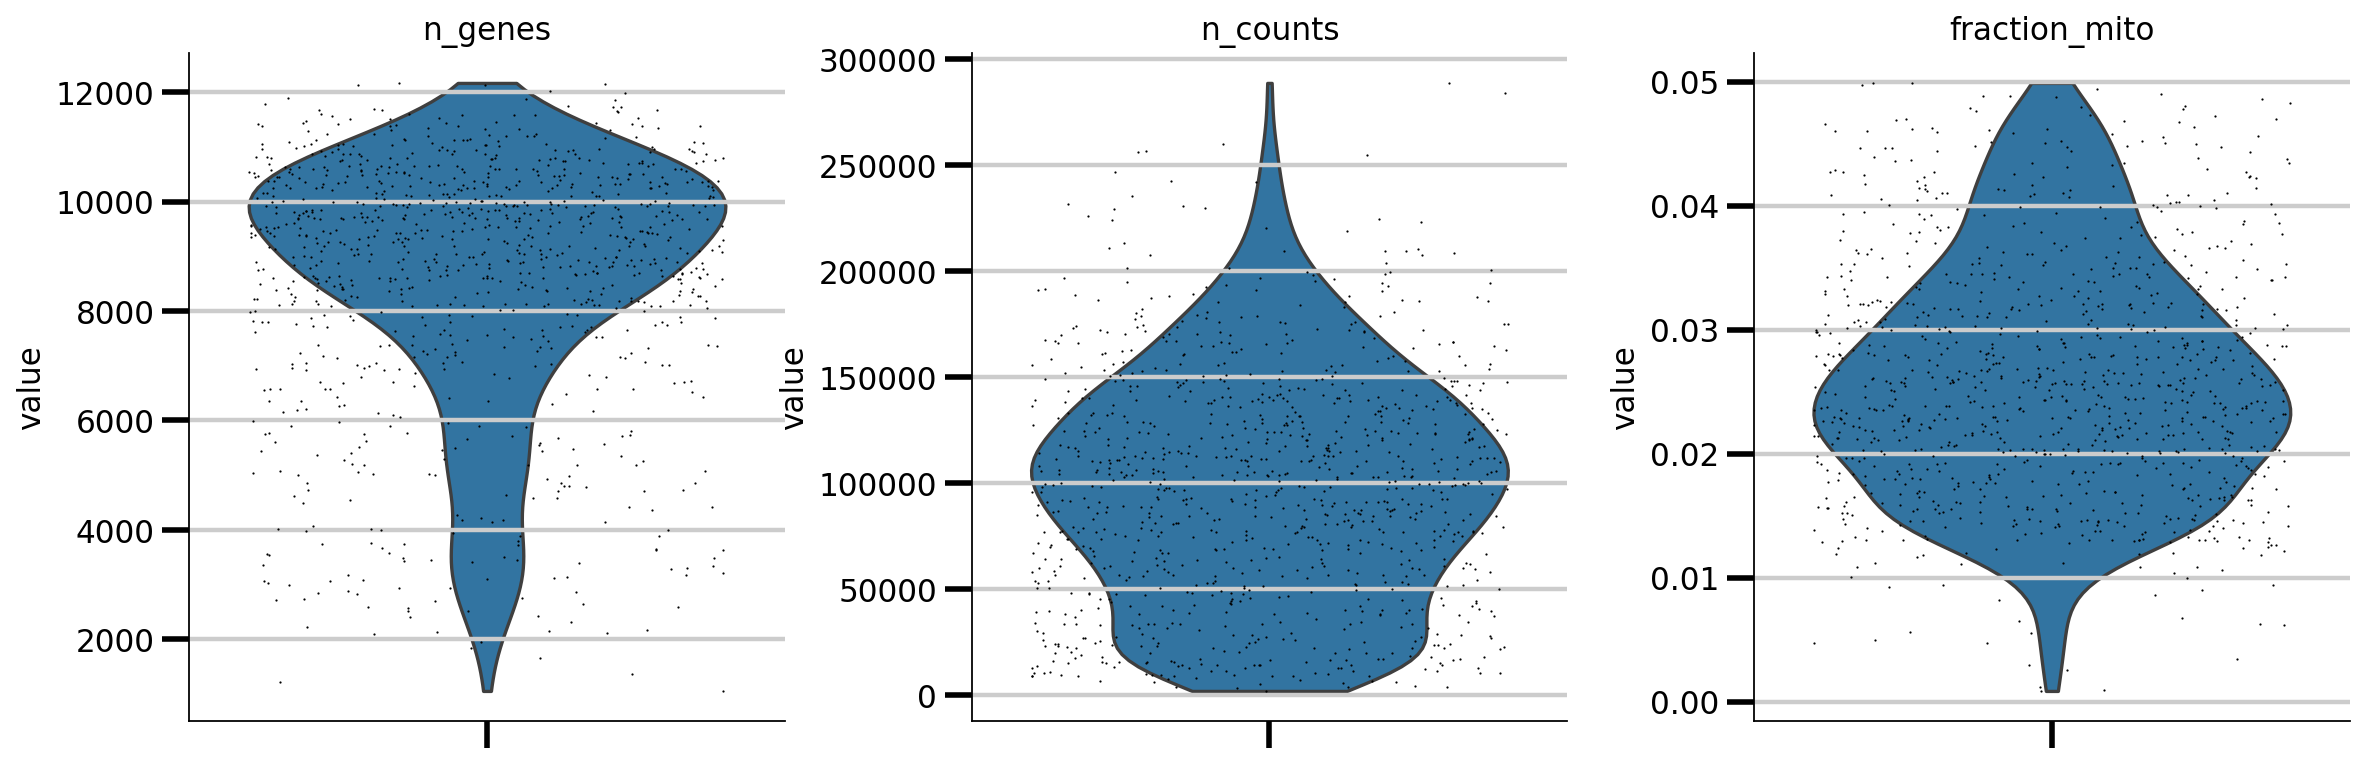

In [16]:
mito_threshold = 0.05
mito_list = []
for i in range(len(adata.obs['fraction_mito'])):
    mito_list.append(adata.obs['fraction_mito'][i])
mito_list_thres = np.where(np.array(mito_list)<mito_threshold)[0]
adata = adata[mito_list_thres,:]
print(adata.shape)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'fraction_mito'],
             jitter=0.4, multi_panel=True)

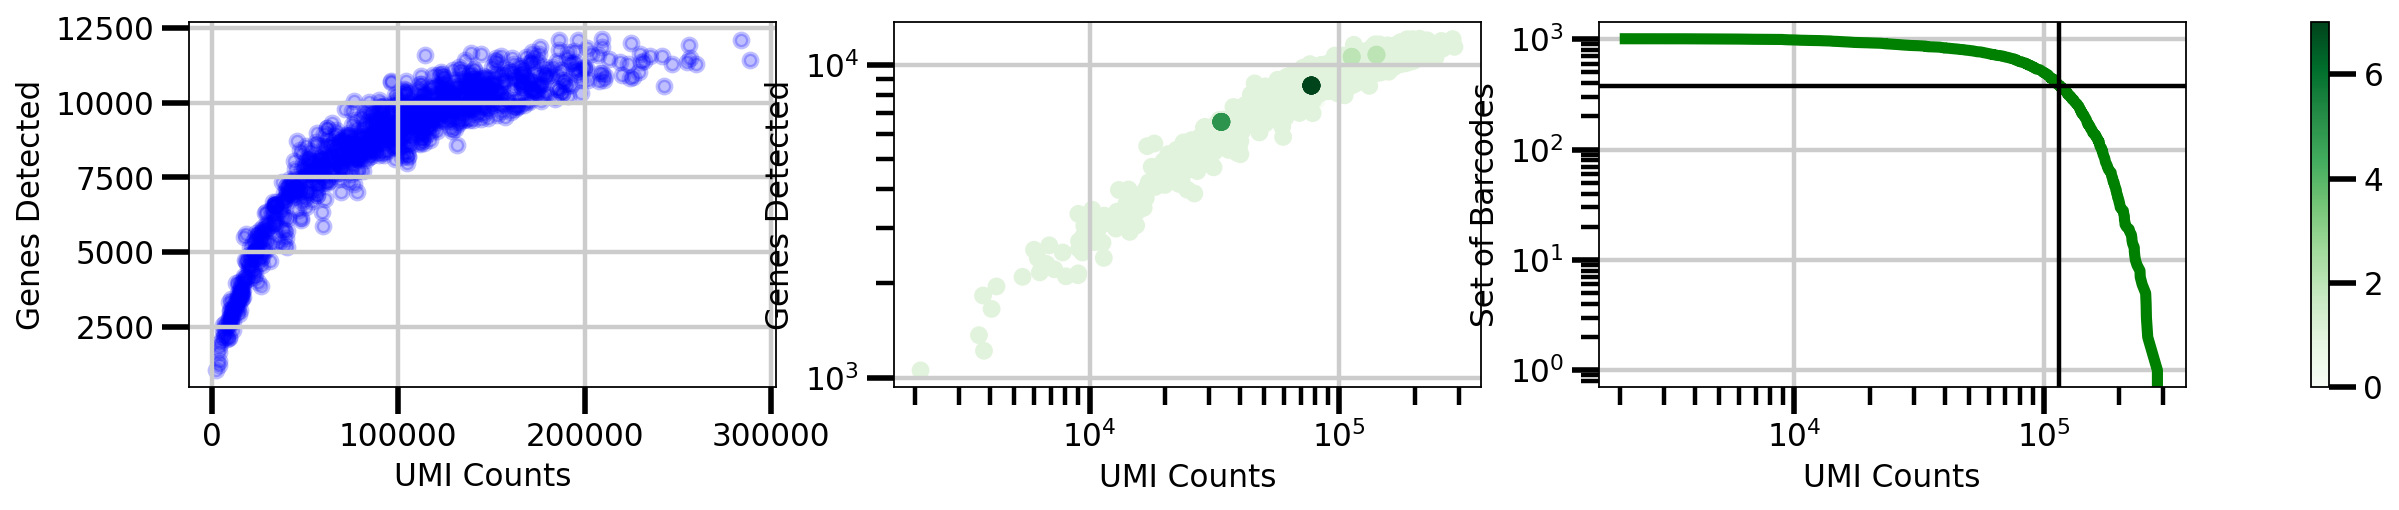

In [17]:
#Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(1,3)
x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]
ax[0].scatter(x, y, color="b", alpha=0.25)
ax[0].set_ylabel("Genes Detected")
ax[0].set_xlabel("UMI Counts")
#ax.set_xscale('log')
#ax.set_yscale('log')

#histogram definition
bins = [1500, 1500] # number of bins
# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)
# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

s = ax[1].scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel("UMI Counts")
ax[1].set_ylabel("Genes Detected")


expected_num_cells =  380#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

ax[2].loglog(knee, range(len(knee)), linewidth=5, color="g")
ax[2].axvline(x=knee[expected_num_cells], linewidth=2, color="k")
ax[2].axhline(y=expected_num_cells, linewidth=2, color="k")

ax[2].set_xlabel("UMI Counts")
ax[2].set_ylabel("Set of Barcodes")

#plt.grid(True, which="both")

fig.set_size_inches([20,3])
plt.show()
fig.savefig(os.path.join(figure_path , 'QC_UMI_genes_counts.png'))

In [18]:
adata = adata[adata.obs.n_genes_by_counts < 12500, :]
adata = adata[adata.obs.pct_counts_mt < 1, :]
print(adata.shape)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes= 15000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

(1012, 25930)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:247: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence thi

    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 15000


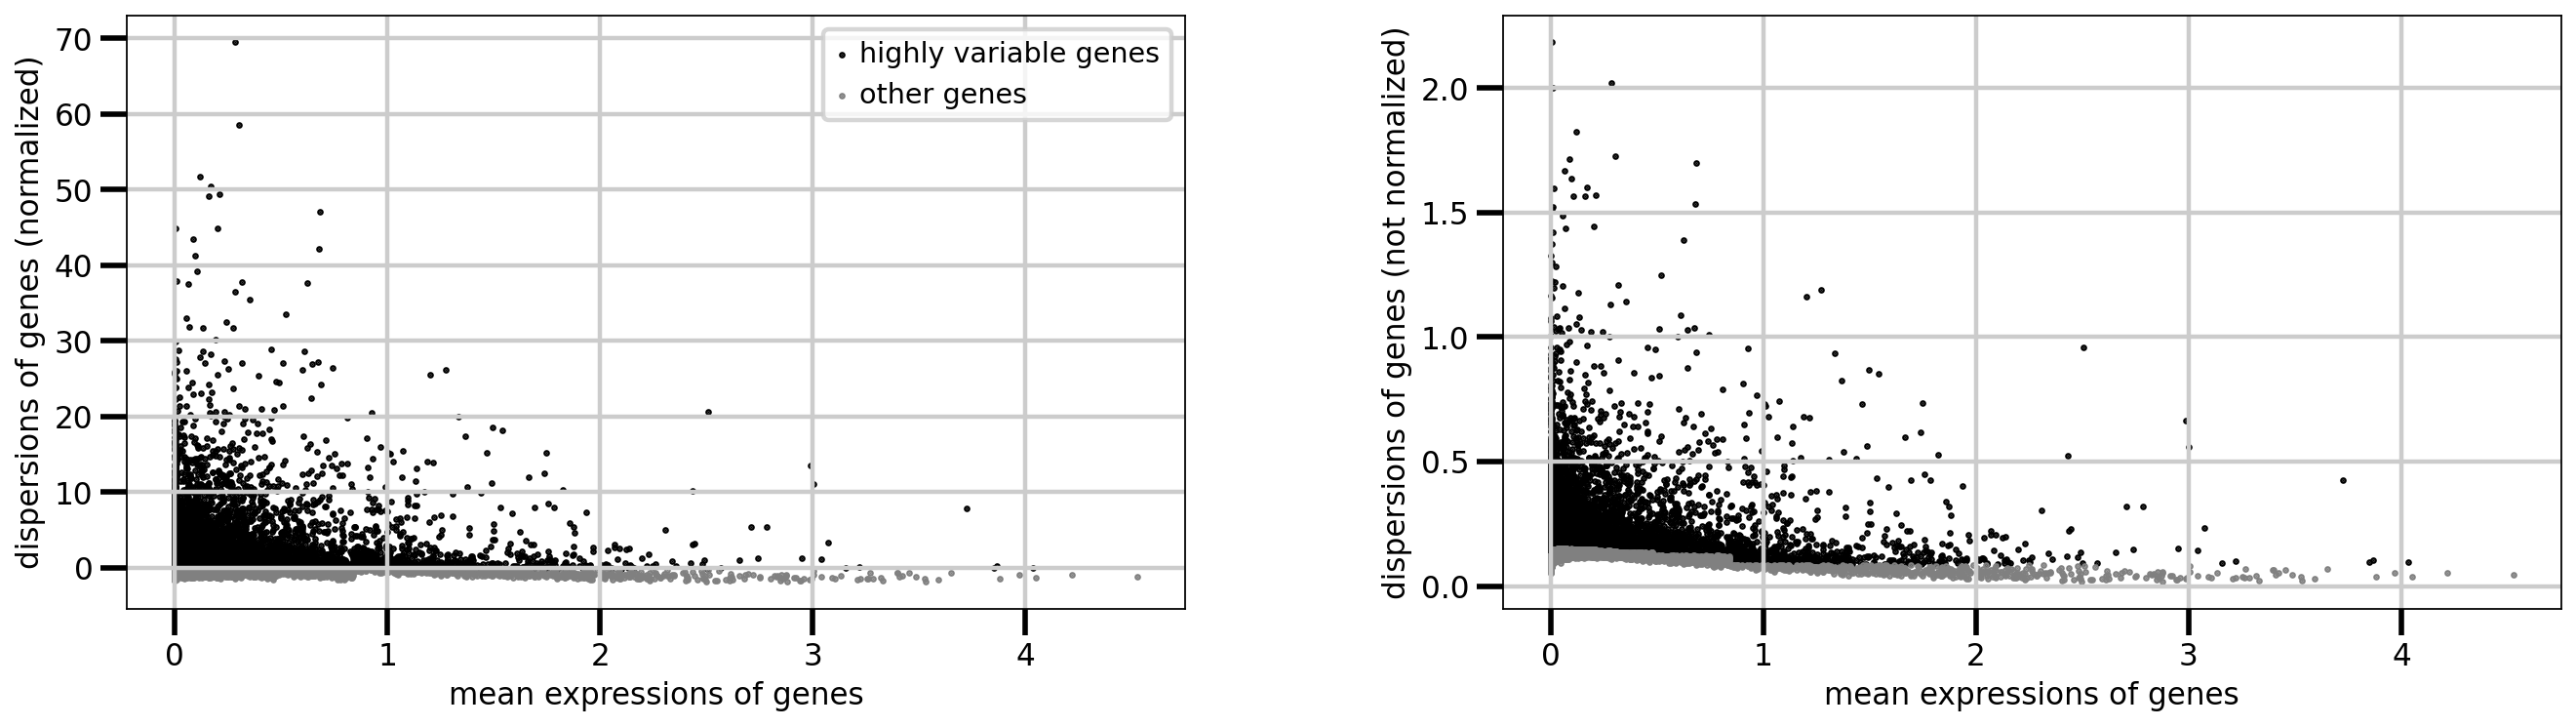

(1012, 25930)


In [19]:
from matplotlib import rcParams

rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

print(adata.shape)

In [20]:
!pip install hdf5plugin
import hdf5plugin

adata.var_names_make_unique() 

adata.write_h5ad(
    os.path.join(output_path , 'campari_scs_all_genes.h5ad'),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


(1012, 15000)


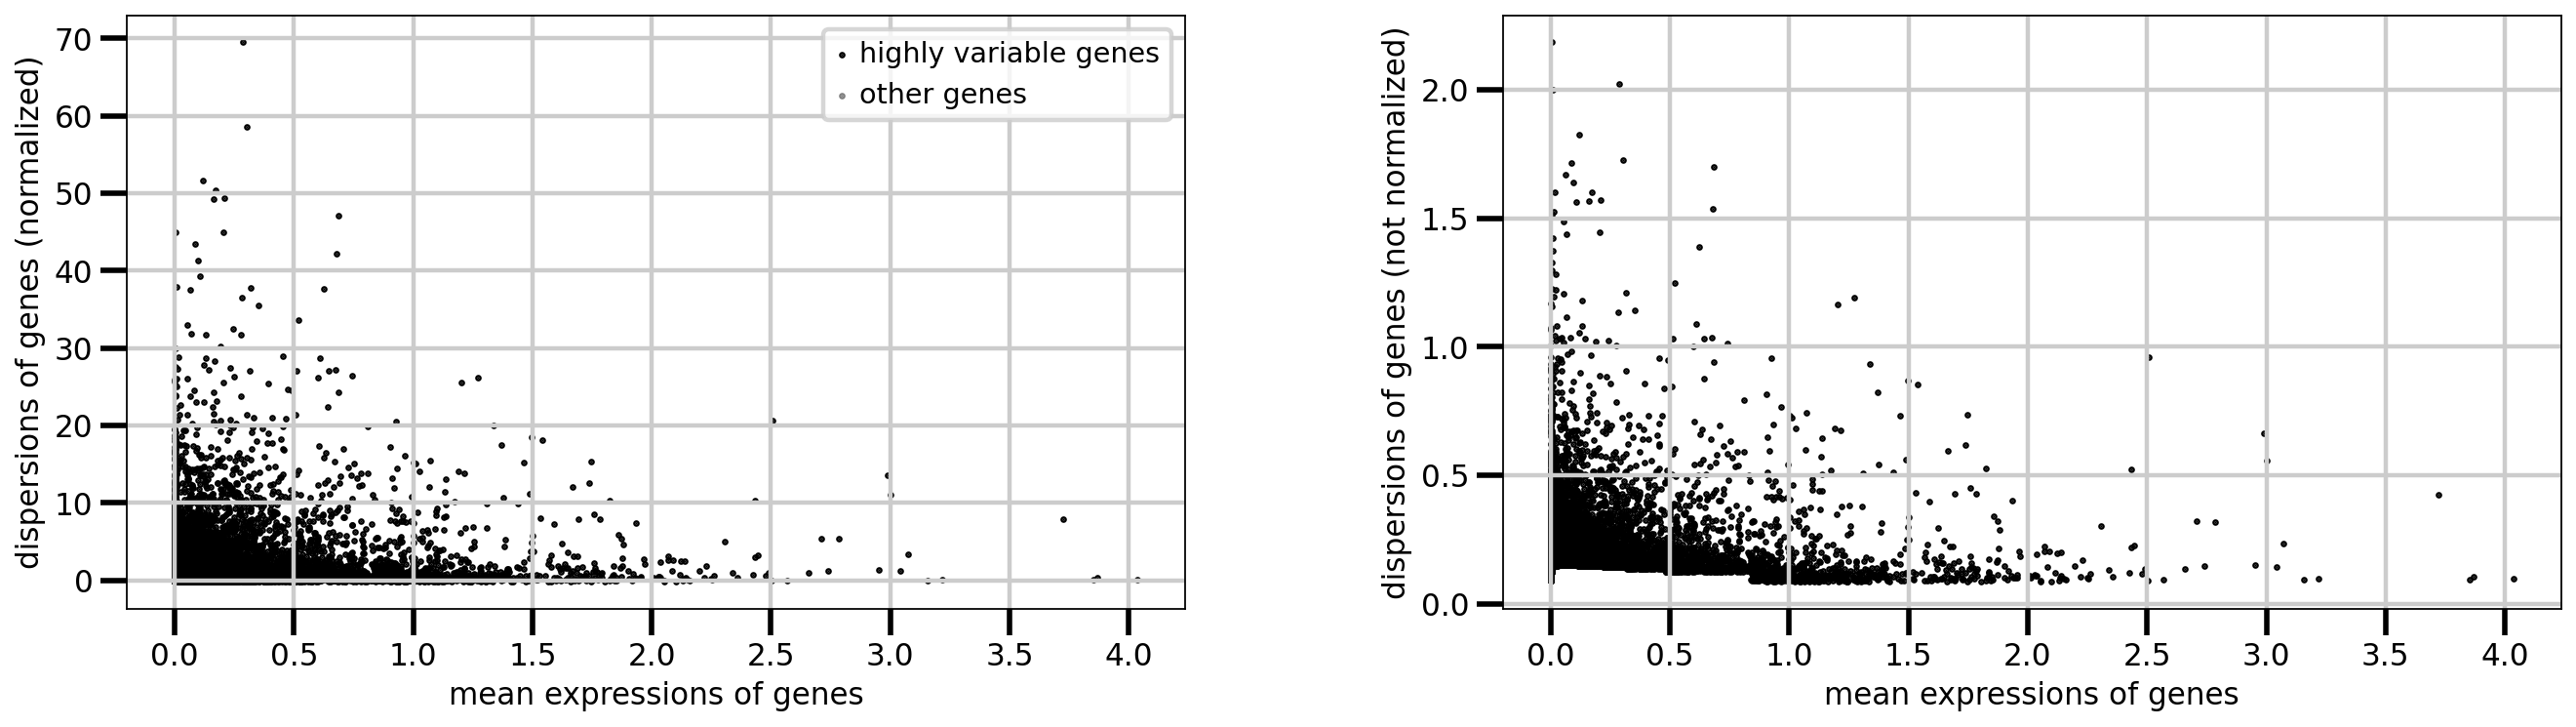

In [21]:
adata = adata[:, adata.var.highly_variable]
print(adata.shape)
sc.pl.highly_variable_genes(adata)

In [22]:

### check again regress_out!!!!!

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:619: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if keys[0] in adata.obs_keys() and is_categorical_dtype(adata.obs[keys[0]]):


    finished (0:00:21)


In [23]:
adata.write_h5ad(
    os.path.join(output_path , 'campari_scs.h5ad'))
#    compression=hdf5plugin.FILTERS["zstd"])
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options)
#adata.write(output_path + 'campari_scs.h5ad')